# **NOₓ Emission Prediction**

## **Introduction**
This project focuses on predicting NOₓ emissions using machine learning models. NOₓ emissions are a significant contributor to climate change, and understanding their patterns can aid in making more informed environmental policies and strategies. By analyzing historical emission data, we aim to develop a model that can predict future emissions and provide insights into emission reduction efforts.

The dataset used in this project provides comprehensive emission data across various regions and sectors, helping us to better understand the sources and trends in NOₓ emissions. This prediction model can help policymakers, environmentalists, and businesses make decisions to reduce emissions and improve sustainability practices.

---

## **Data Collection**
The data for this project was collected from the National Atmospheric Emission Inventory (NAEI), which provides detailed emissions data across various sectors and regions. The data is publicly available at [NAEI Emission Data](https://naei.energysecurity.gov.uk/data/maps/download-gridded-emissions). It includes several key features, which are outlined below:

- **Year**: The year in which the emission data was recorded (e.g., 2010, 2011, etc.).
- **Pollutant_Name**: The name of the pollutant being measured (e.g., NOₓ).
- **PlantID**: A unique identifier for the plant from which the emission data was sourced.
- **Site**: The site or facility name where the emissions occurred.
- **Easting**: The eastward coordinate of the location, used for geographic reference.
- **Northing**: The northward coordinate of the location, used for geographic reference.
- **Operator**: The operator or organization responsible for the emissions.
- **Sector**: The sector responsible for the emissions (e.g., industry, transportation, agriculture).
- **Emission**: The amount of NOₓ emitted in tonnes.
- **Country**: The country where the emissions were recorded..
- **Datatype**: The type of data, which can refer to the method of measurement.

---

## **Importing the libraries**
First we will import the necessary libraries needed for the project's preprocessing

In [ ]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import joblib

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [ ]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

# **1. Loading the Data**

In this step, we loaded all the CSV files from the "Dataset" folder.  
We used Pandas to read each file and added a column to show which file the data came from.  
After that, we combined all the files into one single dataset called `emissions`.  
This makes it easier to work with all the data together in the next steps.


In [ ]:
  # The path of folder for the project

folder_path = '/content/Dataset'

In [ ]:
csv_files = os.listdir(folder_path)

## **1.1 Merging the Datasets**

All the separate CSV files were combined into one big dataset so we can analyze the data easily in one place.


In [ ]:
df_list = []
for file in sorted(csv_files):
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df['Source_File'] = file
    df_list.append(df)

emissions = pd.concat(df_list, ignore_index=True)

In [ ]:
print("Combined DataFrame shape:", emissions.shape)
emissions.head()

Combined DataFrame shape: (44256, 15)


,Year,PollutantID,Pollutant_Name,PlantID,Site,Easting,Northing,Operator,SectorID,Sector,Emission,Unit,Country,Datatype,Source_File
0,2005,6,Nitrogen Oxides as NO2,25,Coventry,434800.0,282300.0,Acordis Acetate Chemicals Ltd,10.0,Chemical industry,75.95,Tonnes,England,O,point_sources_NOx_2005.csv
1,2005,6,Nitrogen Oxides as NO2,28,Spondon,439600.0,336000.0,Acordis Acetate Chemicals Ltd,10.0,Chemical industry,35.33,Tonnes,England,M,point_sources_NOx_2005.csv
2,2005,6,Nitrogen Oxides as NO2,35,Grimsby,523630.0,412140.0,Acordis UK Ltd,10.0,Chemical industry,248.70,Tonnes,England,O,point_sources_NOx_2005.csv
3,2005,6,Nitrogen Oxides as NO2,84,Middlesbrough,458190.0,520340.0,Air Products Plc,3.0,Oil & gas exploration and production,73.54,Tonnes,England,M,point_sources_NOx_2005.csv
4,2005,6,Nitrogen Oxides as NO2,100,Gateshead,428300.0,562600.0,Akzo Nobel Resins Ltd,10.0,Chemical industry,30.00,Tonnes,England,O,point_sources_NOx_2005.csv


In [ ]:
emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44256 entries, 0 to 44255
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            44256 non-null  int64  
 1   PollutantID     44256 non-null  int64  
 2   Pollutant_Name  44256 non-null  object 
 3   PlantID         44256 non-null  int64  
 4   Site            44256 non-null  object 
 5   Easting         44256 non-null  float64
 6   Northing        44256 non-null  float64
 7   Operator        44242 non-null  object 
 8   SectorID        44195 non-null  float64
 9   Sector          44195 non-null  object 
 10  Emission        44256 non-null  float64
 11  Unit            44256 non-null  object 
 12  Country         44256 non-null  object 
 13  Datatype        44256 non-null  object 
 14  Source_File     44256 non-null  object 
dtypes: float64(4), int64(3), object(8)
memory usage: 5.1+ MB


# **2. Data Cleaning**

In this step, we cleaned the dataset to remove unnecessary or problematic data for better analysis.

##**2.1 Dropping Unwanted Columns**

We removed columns that were not useful for our prediction task like IDs and unit names.

In [ ]:
emissions.drop(columns=['PollutantID', 'Pollutant_Name', 'SectorID', 'Unit', 'Source_File'], inplace=True)

##**2.2 Removing Missing Values**

We deleted any rows that had empty (missing) values to avoid errors in the model.

In [ ]:
#missing or null values in data
emissions.isnull().sum()

,0
Year,0
PlantID,0
Site,0
Easting,0
Northing,0
Operator,14
Sector,61
Emission,0
Country,0
Datatype,0


In [ ]:
emissions.dropna(inplace=True)
emissions.isnull().sum()

,0
Year,0
PlantID,0
Site,0
Easting,0
Northing,0
Operator,0
Sector,0
Emission,0
Country,0
Datatype,0


##**2.3 Checking and Removing Duplicates**

We checked for and removed any duplicate rows to keep the data clean and unique.

In [ ]:
duplicate_count = emissions.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [ ]:
emissions.head()

,Year,PlantID,Site,Easting,Northing,Operator,Sector,Emission,Country,Datatype
0,2005,25,Coventry,434800.0,282300.0,Acordis Acetate Chemicals Ltd,Chemical industry,75.95,England,O
1,2005,28,Spondon,439600.0,336000.0,Acordis Acetate Chemicals Ltd,Chemical industry,35.33,England,M
2,2005,35,Grimsby,523630.0,412140.0,Acordis UK Ltd,Chemical industry,248.70,England,O
3,2005,84,Middlesbrough,458190.0,520340.0,Air Products Plc,Oil & gas exploration and production,73.54,England,M
4,2005,100,Gateshead,428300.0,562600.0,Akzo Nobel Resins Ltd,Chemical industry,30.00,England,O


#**3. Exploratory Data Analysis (EDA)**

In this step, we explored the dataset to better understand the data.  
We looked at patterns, trends, and relationships between different features.  
This helps us find important factors that affect NOₓ emissions.  
We also used graphs and charts to visualize the data more clearly and make it easier to understand.

## **3.1 Univariate Analysis**

In univariate analysis, we looked at one feature at a time to understand its distribution and behavior.  
We used plots like histograms and bar charts to see how each individual column, like year or emission value, is spread out.

### **3.1.1 KDE Plot of NOₓ Emissions**

This plot shows how NOₓ emission values are spread out and helps us see which values are most common.


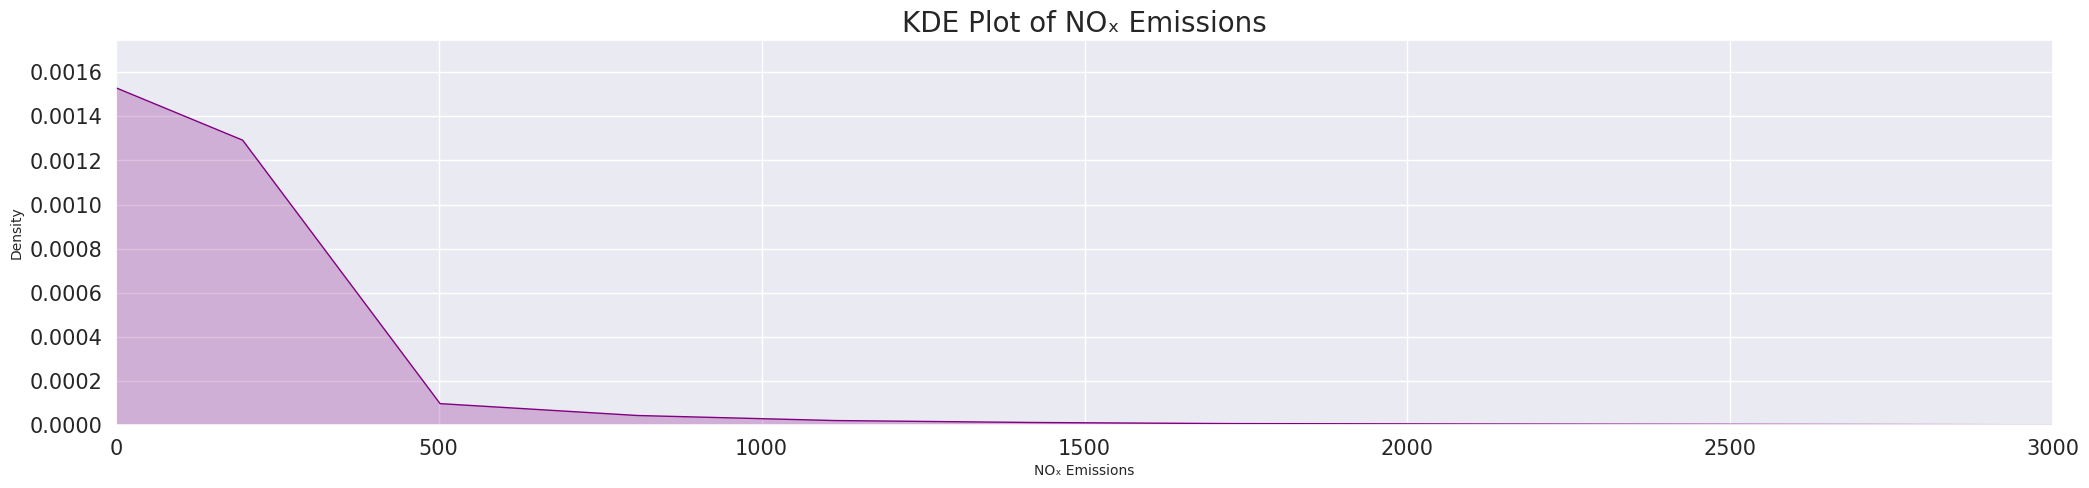

In [ ]:
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 1, sharey=True)

sns.kdeplot(data=emissions, x="Emission", ax=axes, color="purple", shade=True)

axes.set_xlabel("NOₓ Emissions", fontsize=10)
axes.set_ylabel("Density", fontsize=10)
axes.set_title("KDE Plot of NOₓ Emissions", fontsize=20)

axes.set_xlim(0, 3000)

plt.tick_params(labelsize=15)
plt.show()

### **3.1.2 Violin Plot of NOₓ Emissions**

This plot shows the spread and density of NOₓ emissions, helping us see the range and where most values are grouped.


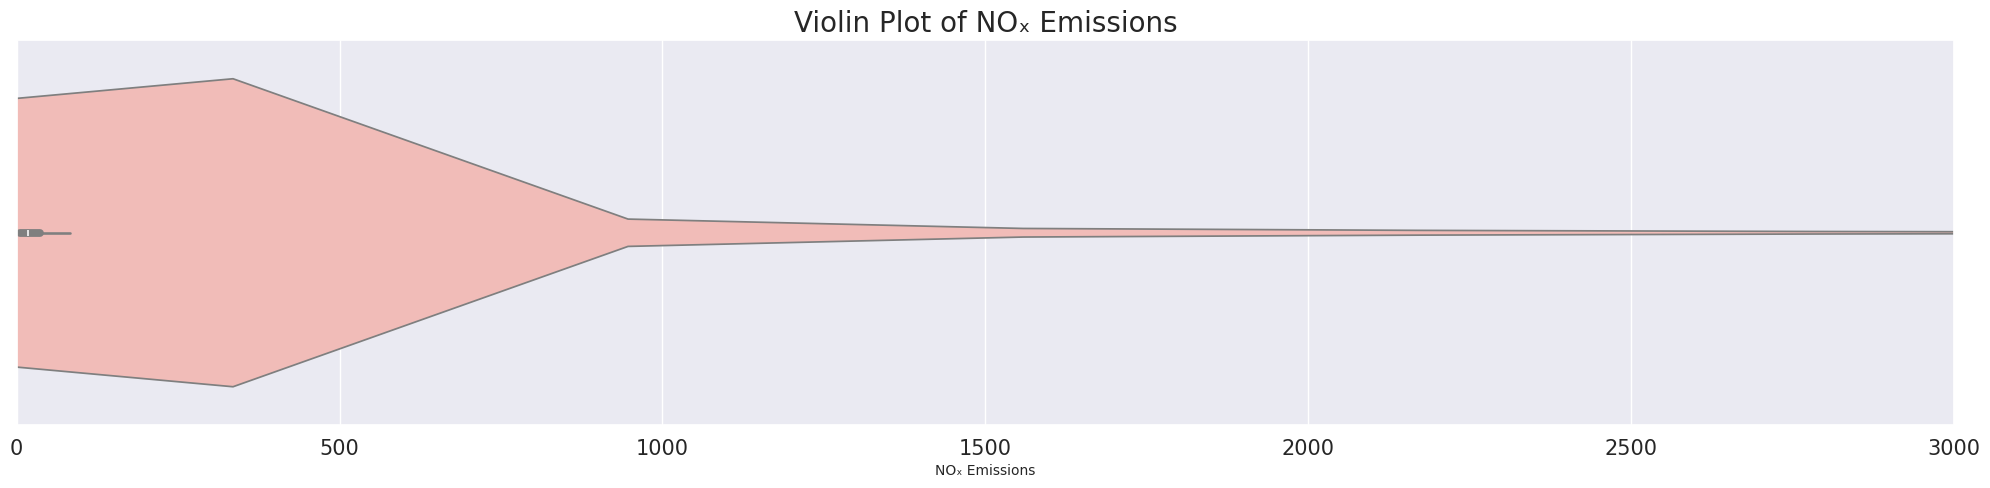

In [ ]:
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 1, sharey=True)

sns.violinplot(data=emissions, x="Emission", ax=axes, palette="Pastel1")

axes.set_xlabel("NOₓ Emissions", fontsize=10)
axes.set_title("Violin Plot of NOₓ Emissions", fontsize=20)

axes.set_xlim(0, 3000)

plt.tick_params(labelsize=15)
plt.show()

### **3.1.3 Countries by Record Count**

This barplot shows how many data records are available for each country, helping us see which countries have the most data.


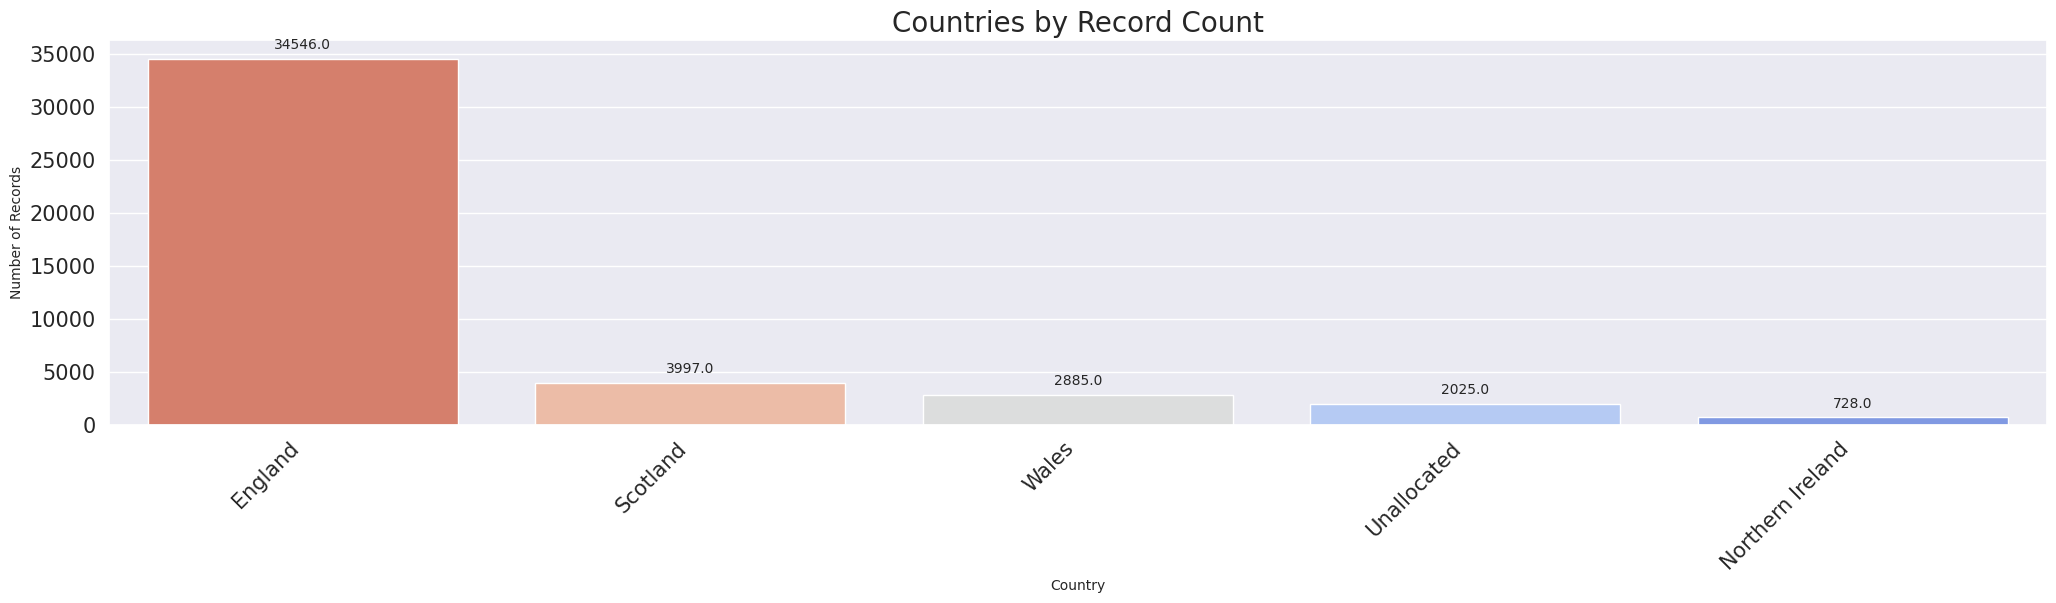

In [ ]:
sns.set(style="darkgrid")

top_countries = emissions['Country'].value_counts().head(10).reset_index()
top_countries.columns = ['Country', 'Count']

fig, axes = plt.subplots(1, 1, sharey=True)

sns.barplot(x="Country", y="Count", data=top_countries, ax=axes, palette="coolwarm_r")
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

for p in axes.patches:
    axes.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.tick_params(labelsize=15)
axes.set_title("Countries by Record Count", fontsize=20)
axes.set_xlabel("Country", fontsize=10)
axes.set_ylabel("Number of Records", fontsize=10)
plt.show()

### **3.1.4 Frequency of Each Datatype**

This plot shows how often each data type appears in the dataset, helping us understand the structure of the data.


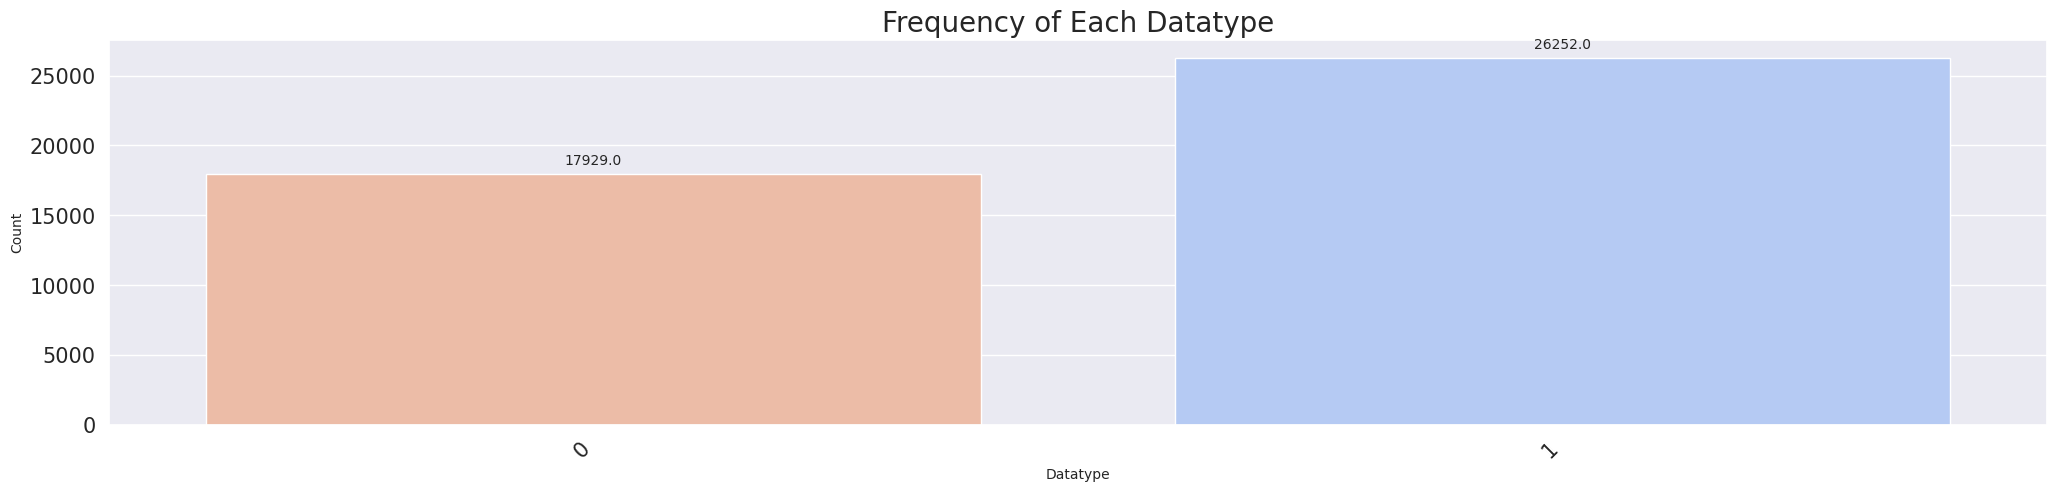

In [ ]:
sns.set(style="darkgrid")

datatype_counts = emissions['Datatype'].value_counts().reset_index()
datatype_counts.columns = ['Datatype', 'Count']

fig, axes = plt.subplots(1, 1, sharey=True)

sns.barplot(x="Datatype", y="Count", data=datatype_counts, ax=axes, palette="coolwarm_r")
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

for p in axes.patches:
    axes.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.tick_params(labelsize=15)
axes.set_title("Frequency of Each Datatype", fontsize=20)
axes.set_xlabel("Datatype", fontsize=10)
axes.set_ylabel("Count", fontsize=10)
plt.show()

### **3.2.1 Top 10 NOₓ Emission Records by Sector**

This plot shows the top 10 sectors with the highest NOₓ emissions, helping us identify the major contributors to pollution.

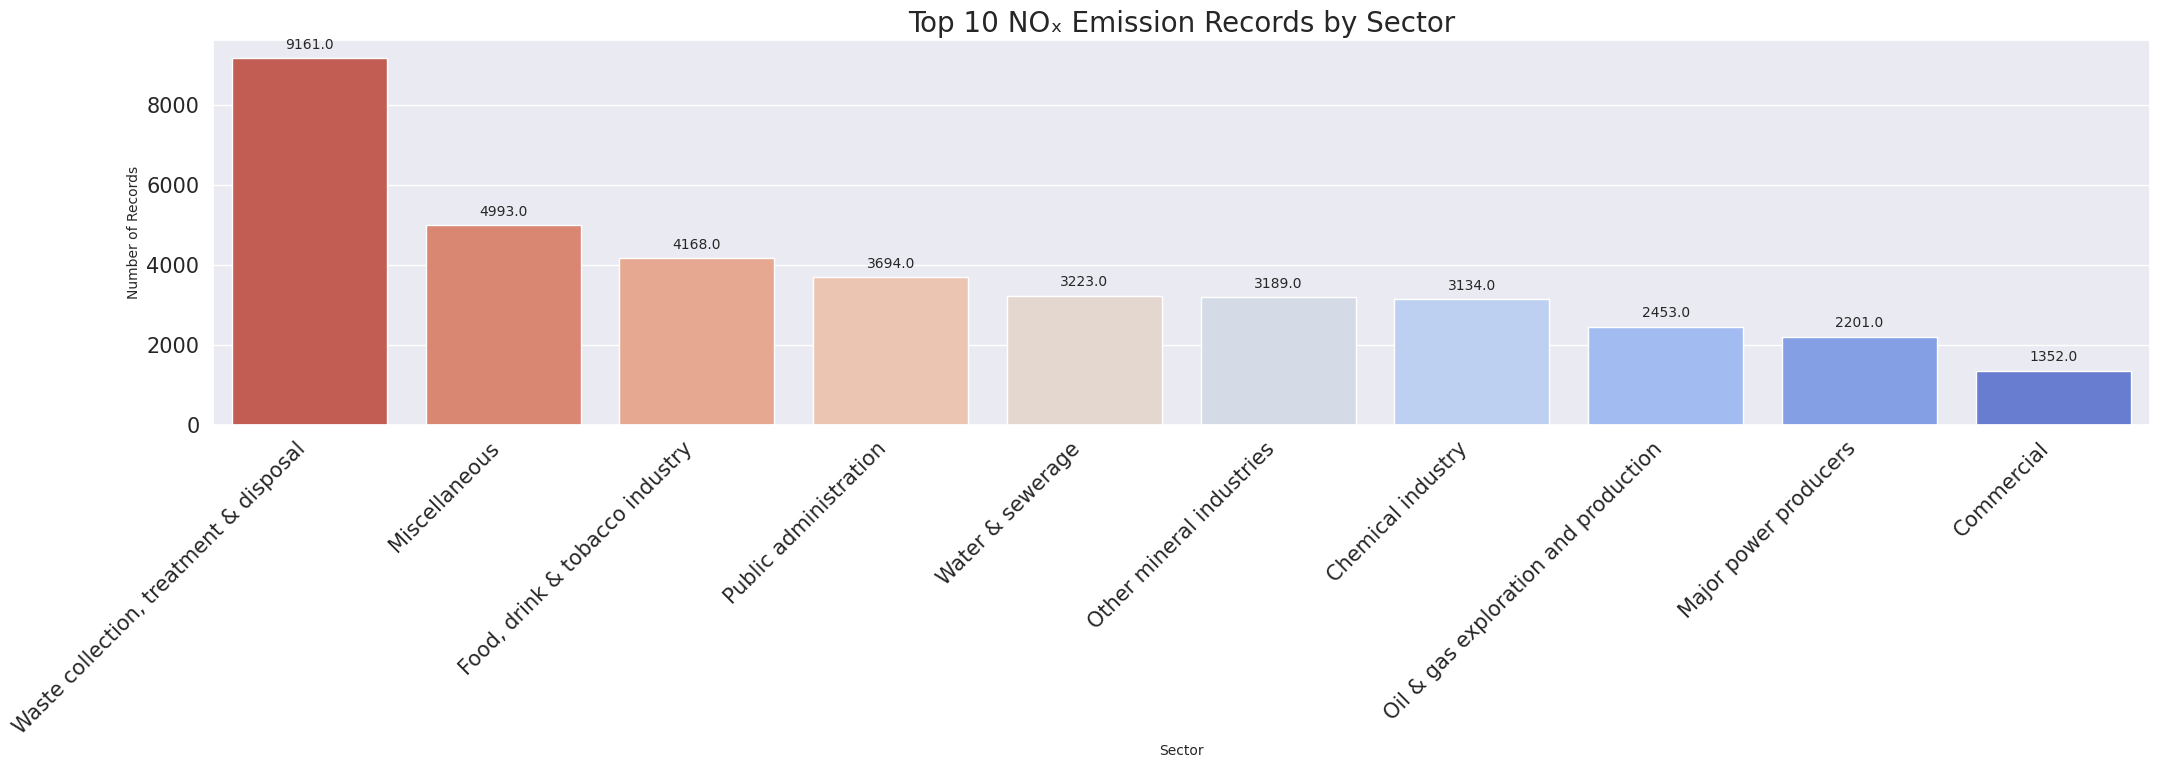

In [ ]:
sns.set(style="darkgrid")

sector_counts = emissions['Sector'].value_counts().reset_index()
sector_counts.columns = ['Sector', 'Count']
sector_counts = sector_counts.head(10)

fig, axes = plt.subplots(1, 1, sharey=True)

sns.barplot(x="Sector", y="Count", data=sector_counts, ax=axes, palette="coolwarm_r")

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

for p in axes.patches:
    axes.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.tick_params(labelsize=15)
axes.set_title("Top 10 NOₓ Emission Records by Sector", fontsize=20)
axes.set_xlabel("Sector", fontsize=10)
axes.set_ylabel("Number of Records", fontsize=10)
plt.show()

### **3.2.2 Number of NOₓ Records per Year (2005–2022)**

This plot shows how many NOₓ emission records were collected each year from 2005 to 2022, helping us see data trends over time.

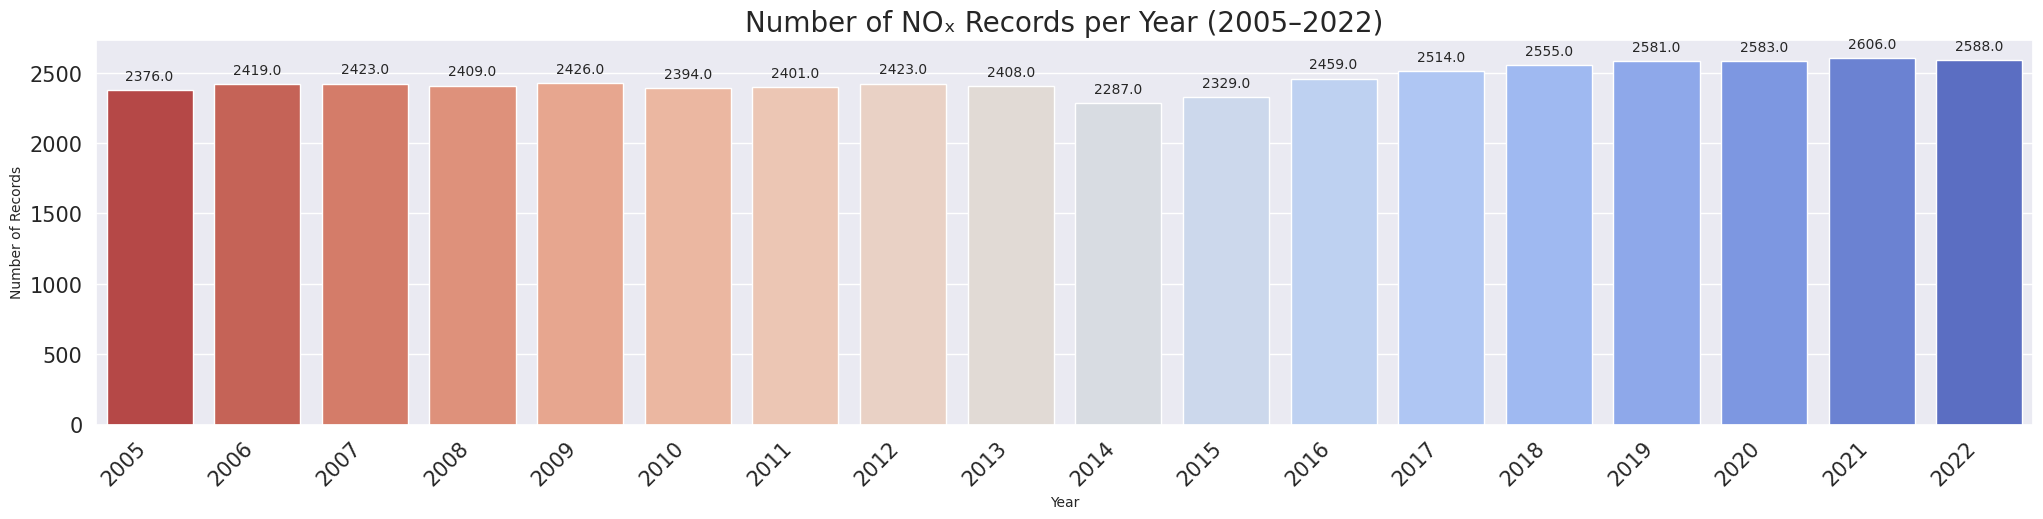

In [ ]:
sns.set(style="darkgrid")

year_counts = emissions[emissions['Year'].between(2005, 2022)]['Year'].value_counts().sort_index().reset_index()
year_counts.columns = ['Year', 'Count']

fig, axes = plt.subplots(1, 1, sharey=True)

sns.barplot(x="Year", y="Count", data=year_counts, ax=axes, palette="coolwarm_r")
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

for p in axes.patches:
    axes.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.tick_params(labelsize=15)
axes.set_title("Number of NOₓ Records per Year (2005–2022)", fontsize=20)
axes.set_xlabel("Year", fontsize=10)
axes.set_ylabel("Number of Records", fontsize=10)
plt.show()

## **3.2 Bivariate Analysis**

In bivariate analysis, we studied the relationship between two features at a time.  
This helped us understand how one feature affects another, such as how emissions change over the years or vary across sectors.

### **3.2.1 NOₓ Emissions by Top 10 Sectors**

This plot shows how much NOₓ each of the top 10 sectors produced, helping us compare emissions across different sectors.


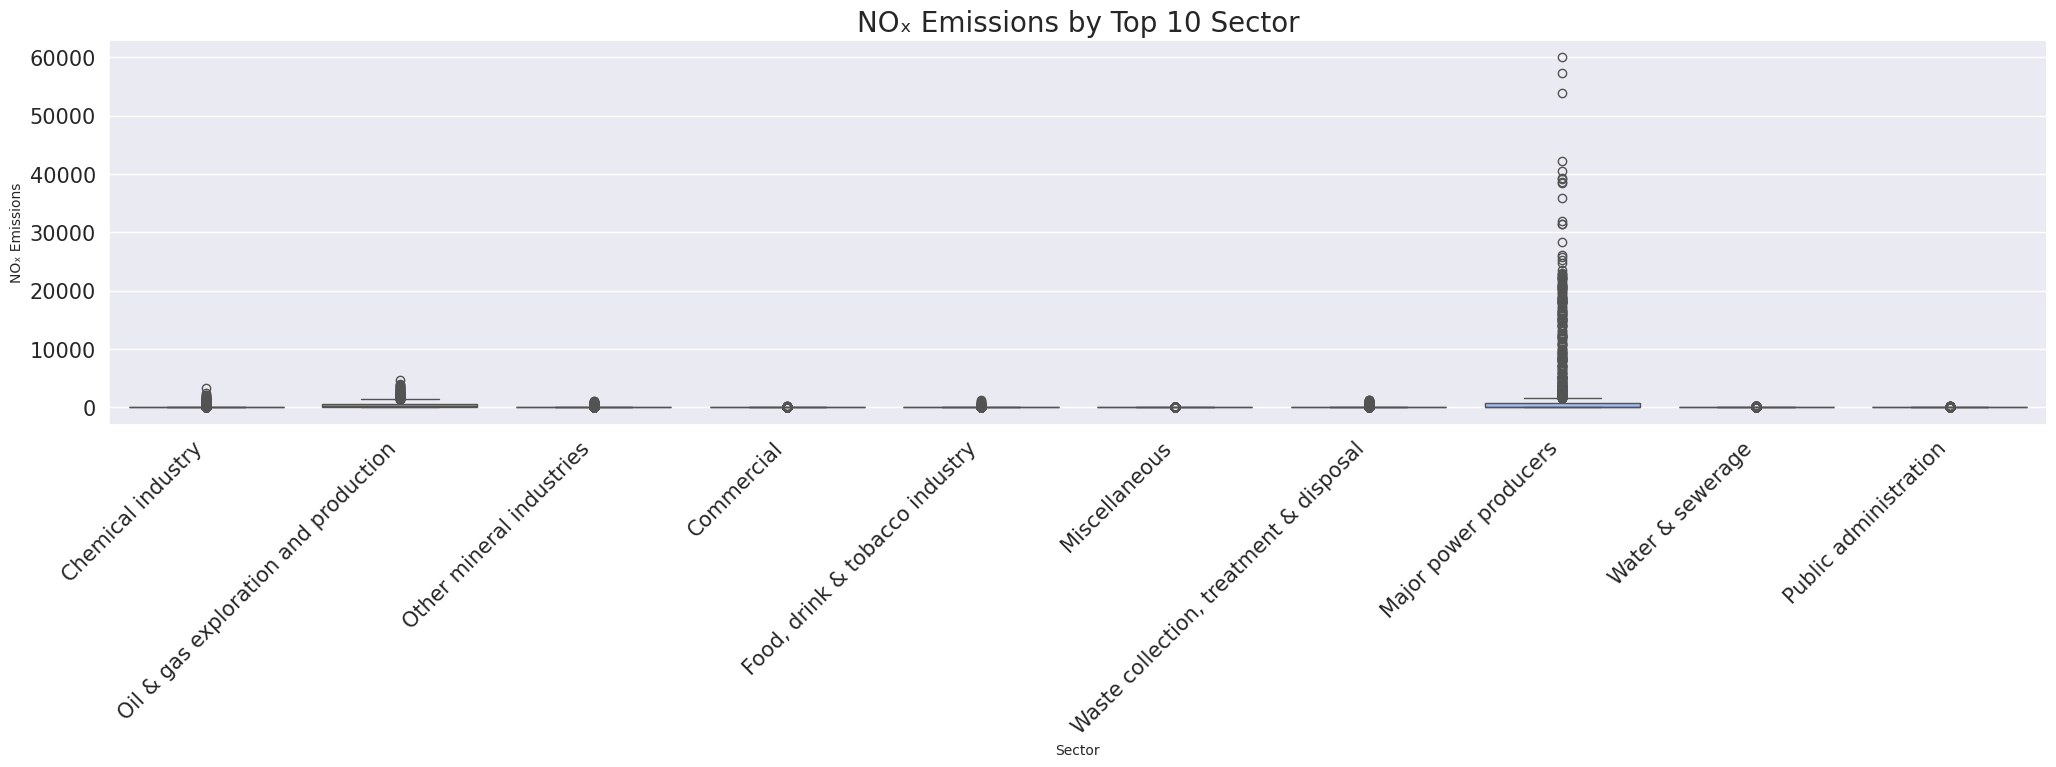

In [ ]:
sns.set(style="darkgrid")

top_10_sectors = emissions['Sector'].value_counts().head(10).index

filtered_data = emissions[emissions['Sector'].isin(top_10_sectors)]

fig, axes = plt.subplots(1, 1, sharey=True)

sns.boxplot(x="Sector", y="Emission", data=filtered_data, ax=axes, palette="coolwarm_r")

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

plt.tick_params(labelsize=15)
axes.set_title("NOₓ Emissions by Top 10 Sector", fontsize=20)
axes.set_xlabel("Sector", fontsize=10)
axes.set_ylabel("NOₓ Emissions", fontsize=10)
plt.show()

### **3.2.2 NOₓ Emissions by Datatype**

This plot compares the distribution of NOₓ emissions for each data type, helping us see how emission values vary by type.

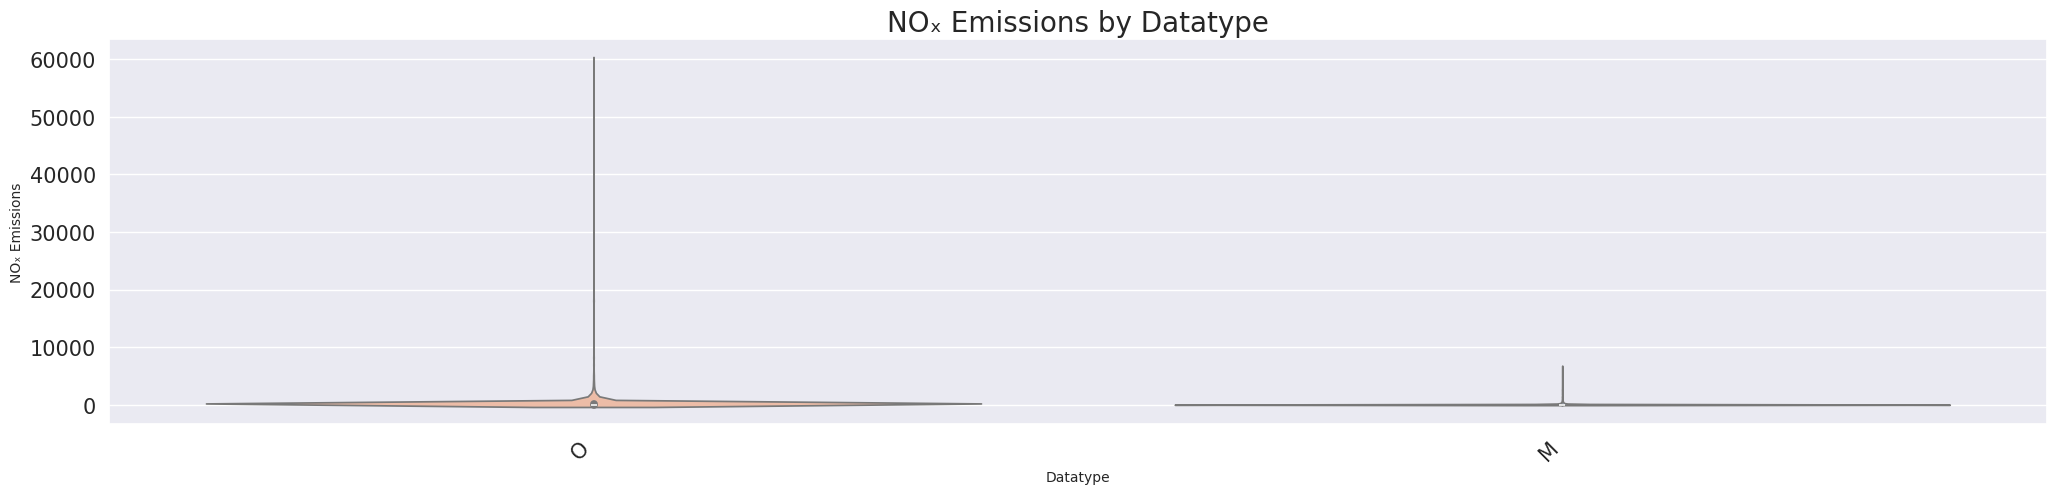

In [ ]:
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 1, sharey=True)

sns.violinplot(x="Datatype", y="Emission", data=emissions, ax=axes, palette="coolwarm_r")

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

plt.tick_params(labelsize=15)
axes.set_title("NOₓ Emissions by Datatype", fontsize=20)
axes.set_xlabel("Datatype", fontsize=10)
axes.set_ylabel("NOₓ Emissions", fontsize=10)
plt.show()

### **3.2.3 Emission by Year**

This boxplot shows the distribution of NOₓ emissions for each year, helping us understand yearly trends and detect any outliers.

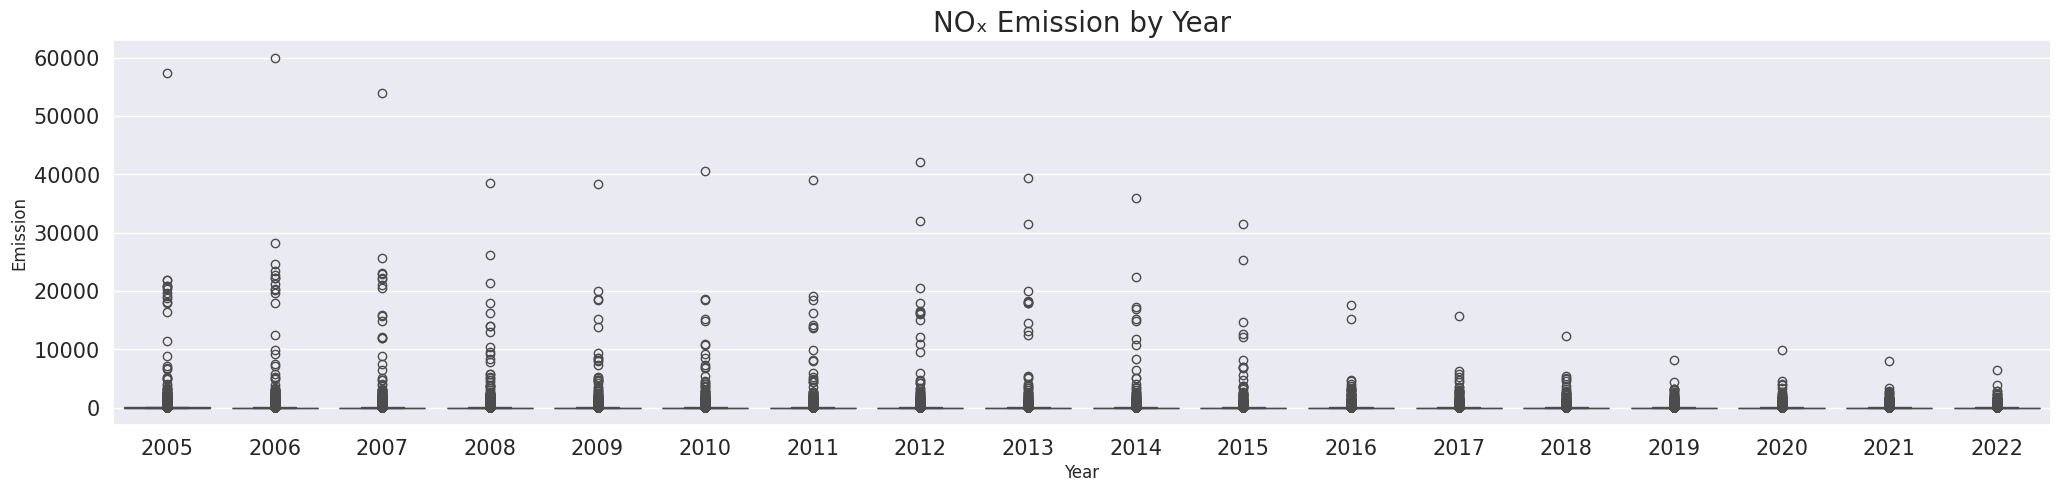

In [ ]:
sns.set(style="darkgrid")

sns.boxplot(x='Year', y='Emission', data=emissions)

plt.title("NOₓ Emission by Year", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

### **3.2.4 Emission Distribution by Country (Top 5)**

This plot displays the distribution of NOₓ emissions for the top 5 countries, helping us compare emissions across these countries.

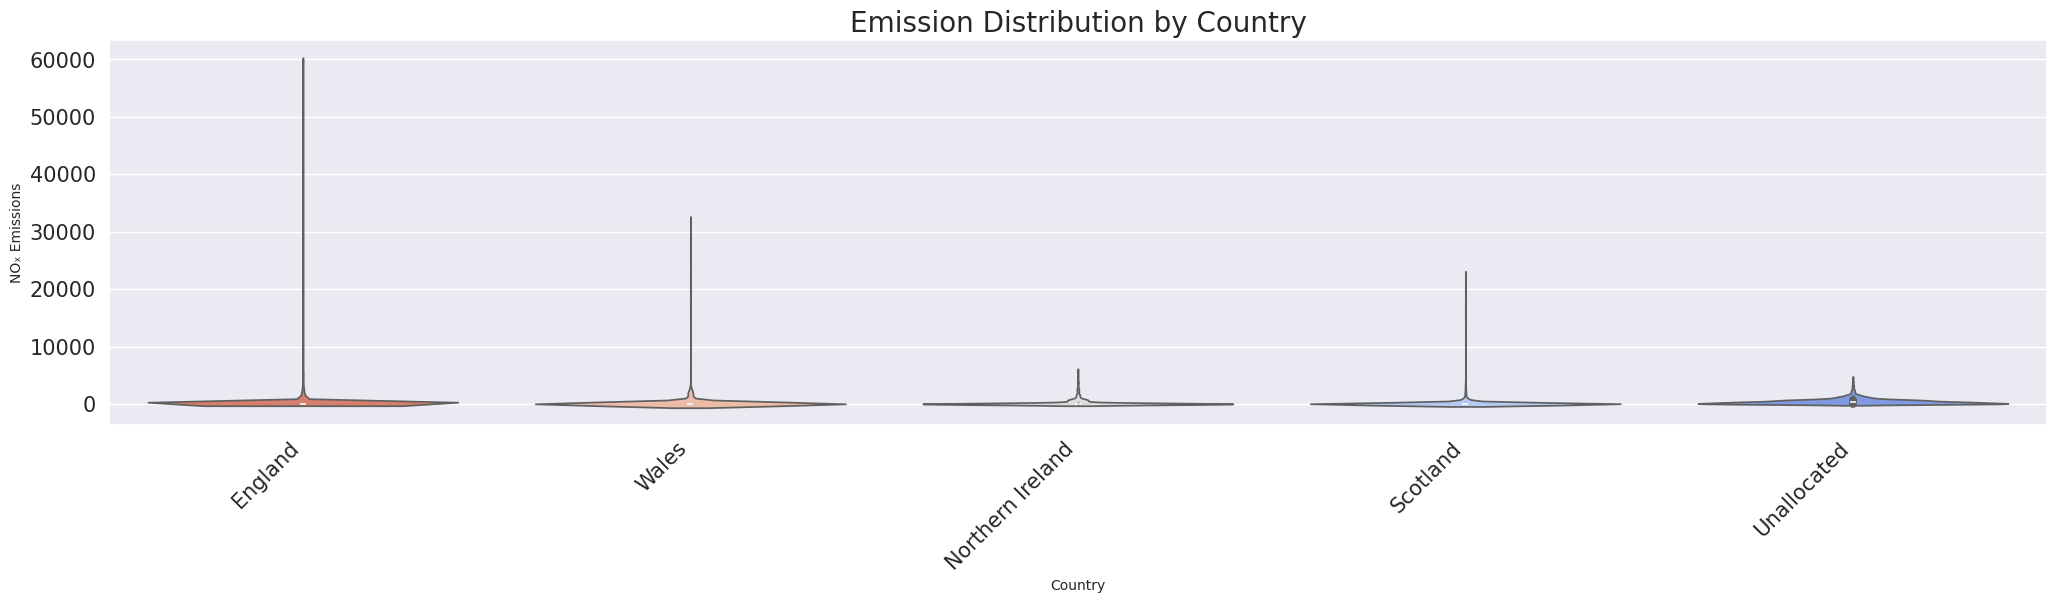

In [ ]:
sns.set(style="darkgrid")

top_countries = emissions['Country'].value_counts().head(5).index
df_top_countries = emissions[emissions['Country'].isin(top_countries)]

fig, axes = plt.subplots(1, 1, sharey=True)

sns.violinplot(x="Country", y="Emission", data=df_top_countries, ax=axes, palette="coolwarm_r")
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

plt.tick_params(labelsize=15)
axes.set_title("Emission Distribution by Country", fontsize=20)
axes.set_xlabel("Country", fontsize=10)
axes.set_ylabel("NOₓ Emissions", fontsize=10)
plt.show()

### **3.2.5 Geographical Distribution of Emissions (Easting vs Northing)**

This scatter plot shows the geographical distribution of NOₓ emissions based on easting and northing coordinates, helping us visualize emission patterns across locations.


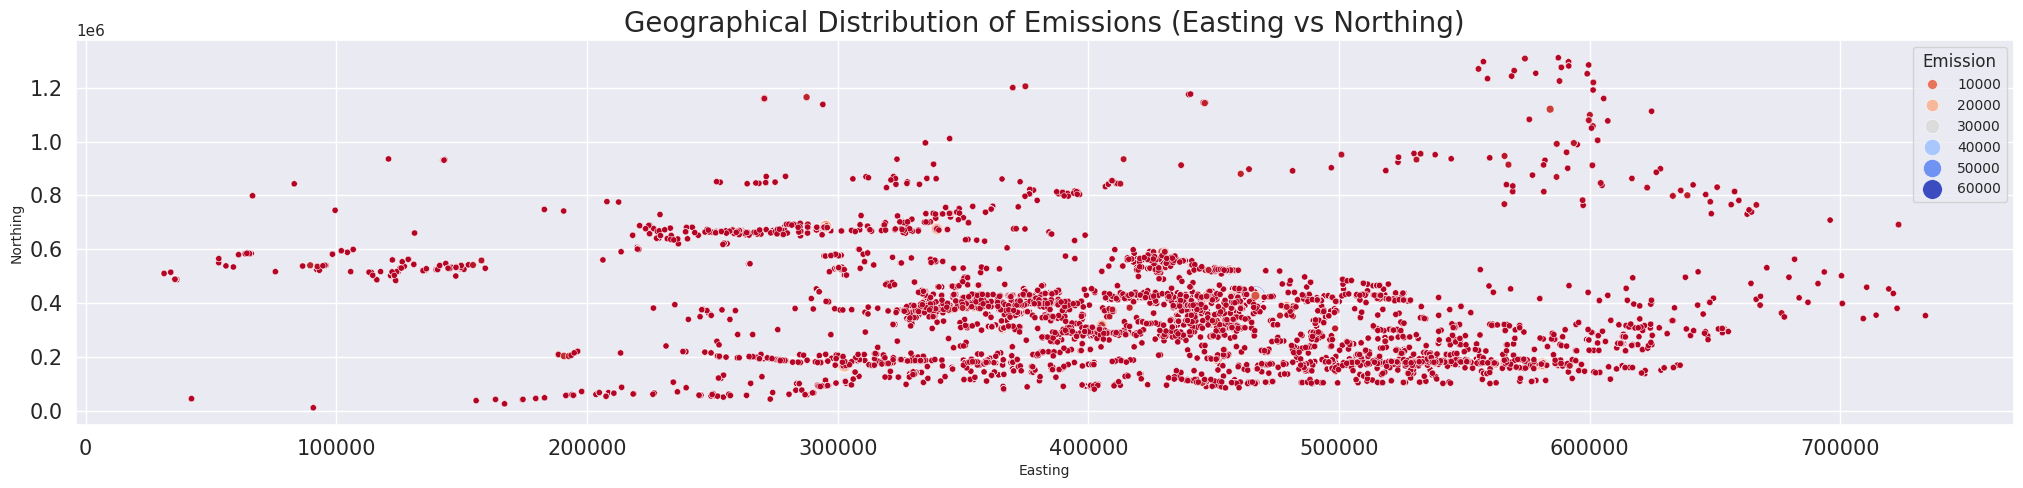

In [ ]:
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 1, sharey=True)

sns.scatterplot(x="Easting", y="Northing", hue="Emission", data=emissions, ax=axes, palette="coolwarm_r", size="Emission", sizes=(20, 200))

plt.tick_params(labelsize=15)
axes.set_title("Geographical Distribution of Emissions (Easting vs Northing)", fontsize=20)
axes.set_xlabel("Easting", fontsize=10)
axes.set_ylabel("Northing", fontsize=10)
plt.legend(title='Emission', fontsize=10)
plt.show()

### **3.2.6 Total NOₓ Emissions per Year**

This plot shows the total NOₓ emissions for each year, helping us track the overall emission trends over time.

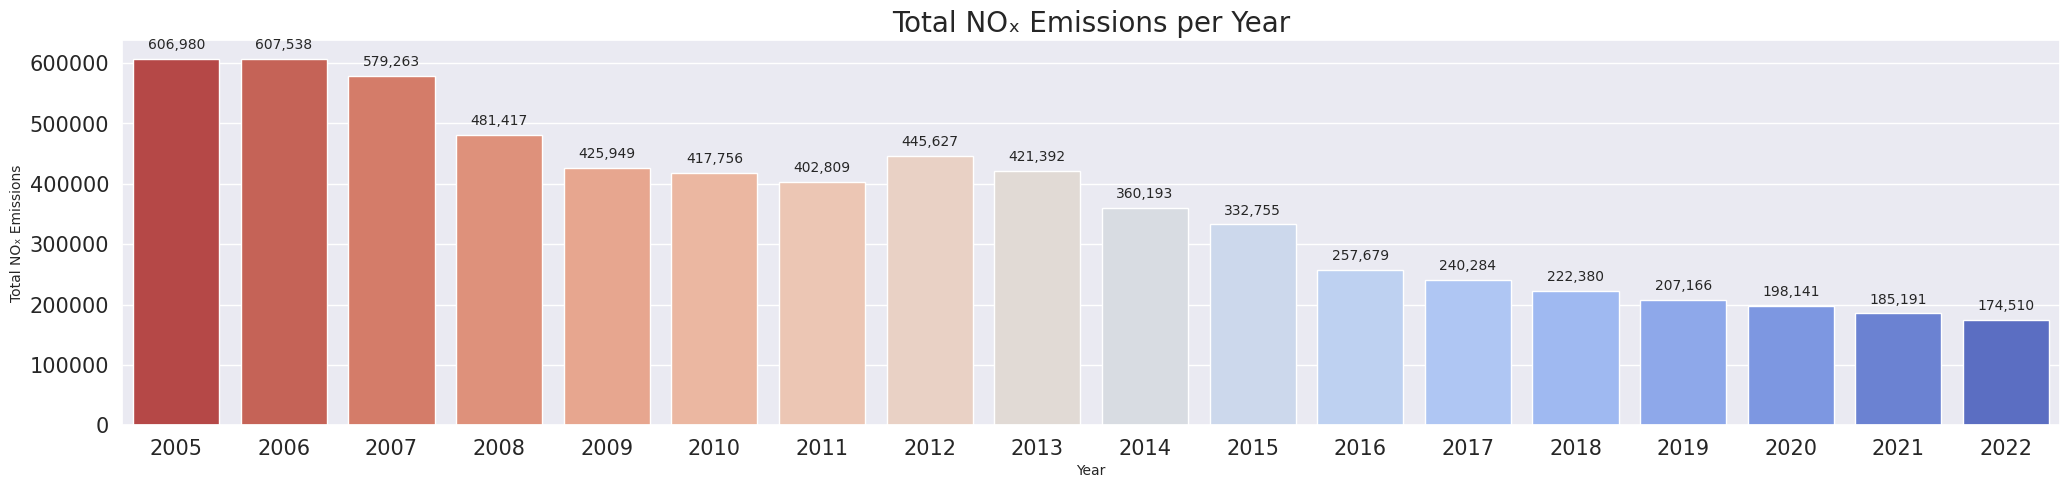

In [ ]:
sns.set(style="darkgrid")

yearly_emission = emissions.groupby('Year')['Emission'].sum().reset_index()

fig, axes = plt.subplots(1, 1, sharey=True)

sns.barplot(x="Year", y="Emission", data=yearly_emission, ax=axes, palette="coolwarm_r")

for p in axes.patches:
    axes.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.tick_params(labelsize=15)
axes.set_title("Total NOₓ Emissions per Year", fontsize=20)
axes.set_xlabel("Year", fontsize=10)
axes.set_ylabel("Total NOₓ Emissions", fontsize=10)
plt.show()

### **3.2.7 Correlation Heatmap**

This heatmap shows the correlation between easting, northing, and NOₓ emissions, helping us understand how these variables are related to each other.


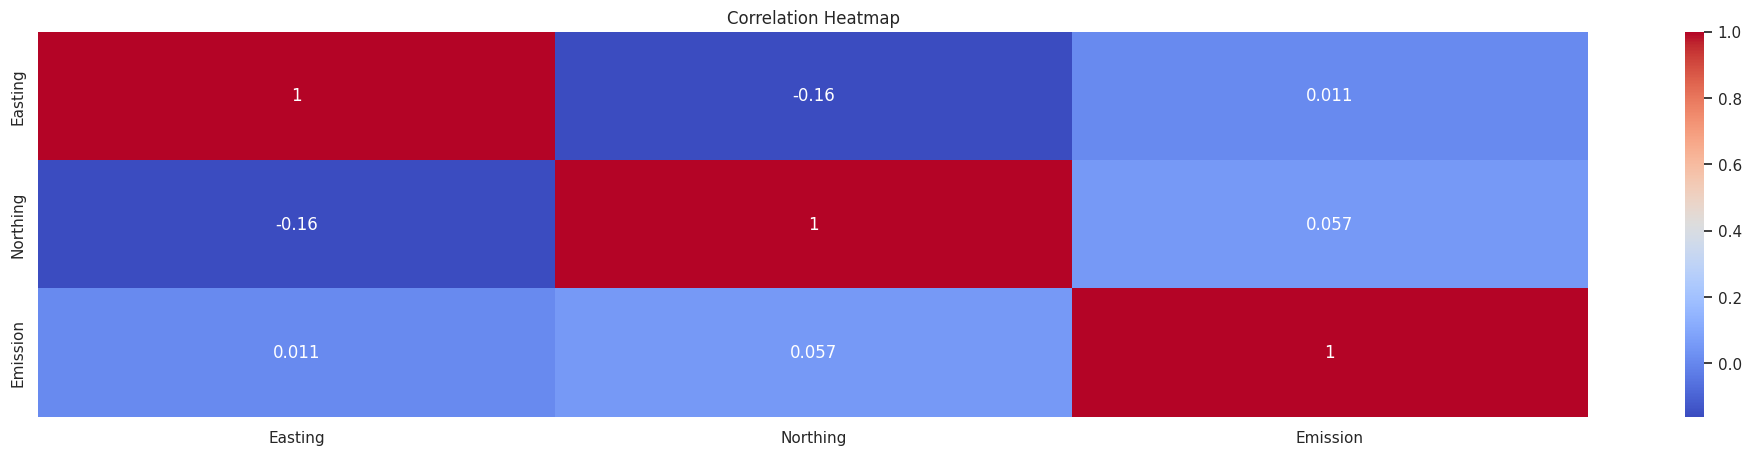

In [ ]:
correlation_matrix = emissions[['Easting', 'Northing', 'Emission']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### **3.2.8 Top 10 Emissions per Sector and Datatype (Barplot)**

This barplot shows the top 10 sectors and their NOₓ emissions categorized by datatype, helping us compare emissions across different sectors and data types.

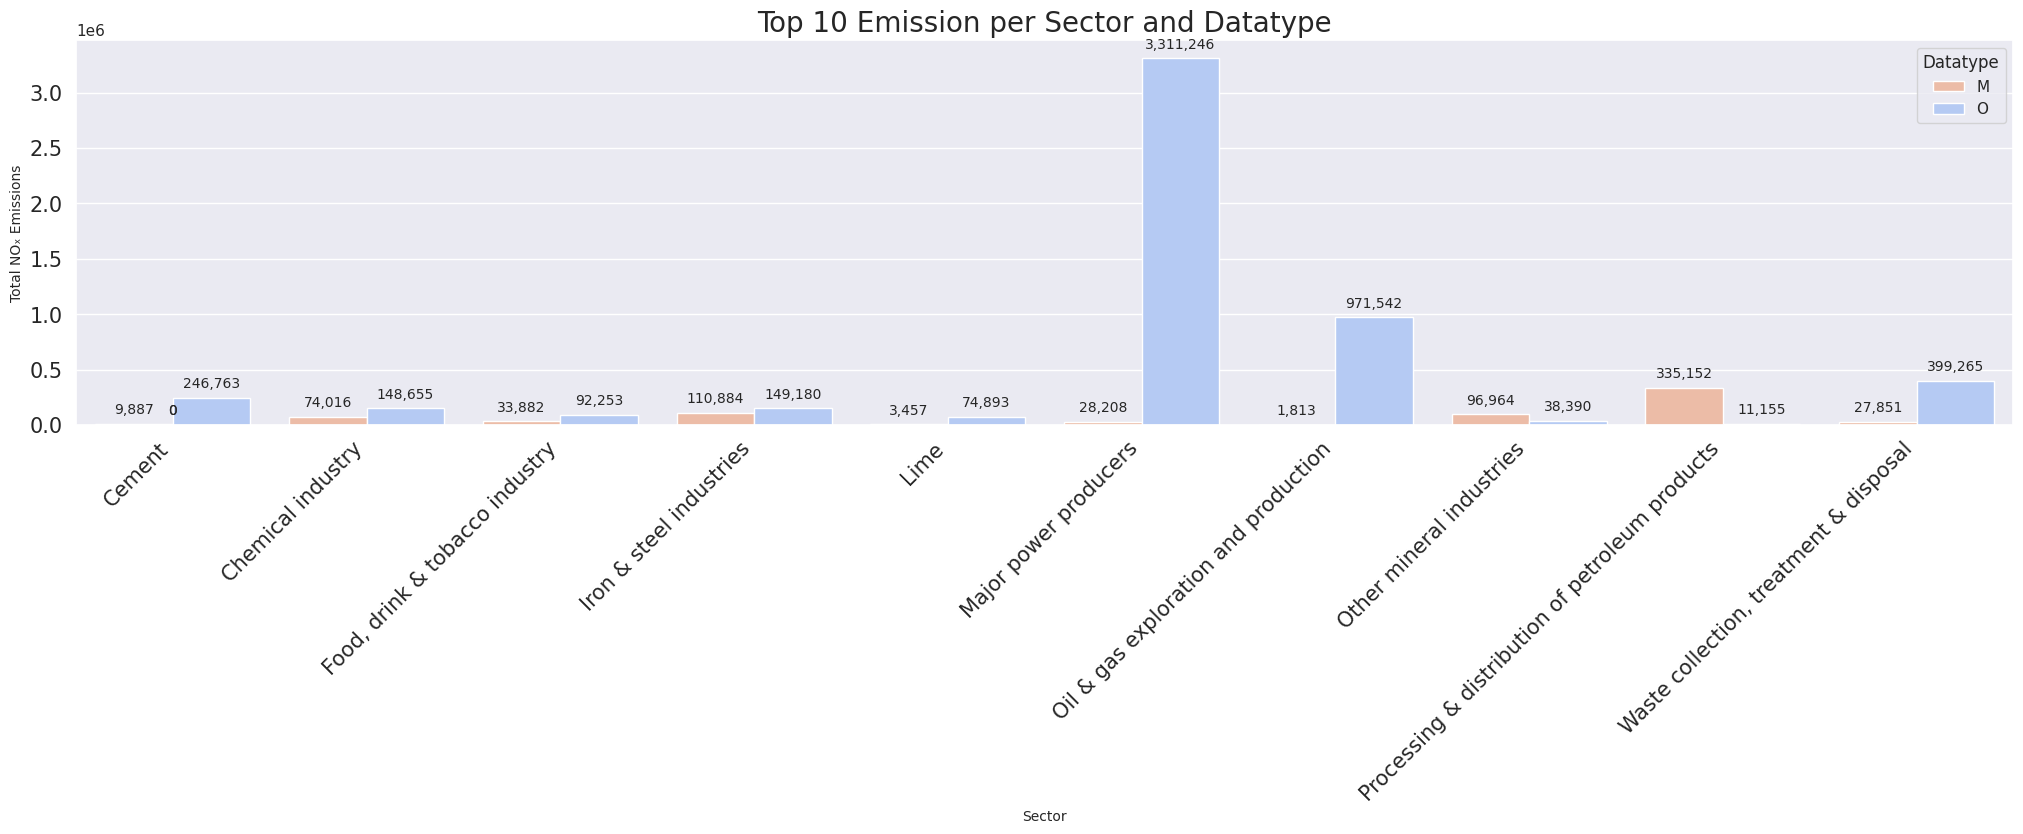

In [ ]:
sector_datatype_emission = emissions.groupby(['Sector', 'Datatype'])['Emission'].sum().reset_index()

top_10_sectors = sector_datatype_emission.groupby('Sector')['Emission'].sum().sort_values(ascending=False).head(10).index

filtered_data = sector_datatype_emission[sector_datatype_emission['Sector'].isin(top_10_sectors)]

sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 1, sharey=True)

sns.barplot(x="Sector", y="Emission", hue="Datatype", data=filtered_data, ax=axes, palette="coolwarm_r")

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", fontsize=12)

for p in axes.patches:
    axes.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.tick_params(labelsize=15)
axes.set_title("Top 10 Emission per Sector and Datatype", fontsize=20)
axes.set_xlabel("Sector", fontsize=10)
axes.set_ylabel("Total NOₓ Emissions", fontsize=10)

plt.show()

# **4. Feature Engineering**

Feature engineering helps improve the quality of the data by creating new features and preparing the data for machine learning models.  
In this step, we grouped data, encoded categorical features, and scaled the data to make it ready for modeling.



## **4.1 Grouping the Operator Column**

We grouped the operators into categories by counting how often each one appears.  
Operators that appeared less than 50 times were grouped into an "Other" category, making the data simpler and cleaner.

In [ ]:
operator_counts = emissions['Operator'].value_counts()
common_operators = operator_counts[operator_counts >= 50].index
emissions['Operator_Grouped'] = emissions['Operator'].apply(lambda x: x if x in common_operators else 'Other')
emissions.drop(columns=['Operator'], inplace=True)

## **4.2 Encoding Categorical Variables**

We encoded categorical columns like 'Operator' and other text-based features into numerical values using Label Encoding.  
This makes it easier for machine learning models to work with the data. The encoders were saved so we can use them later.

In [ ]:
label_encoders = {}
categorical_cols = emissions.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    emissions[col] = le.fit_transform(emissions[col])
    label_encoders[col] = le
    joblib.dump(le, folder_path + f'label_encoder_{col}.pkl')

## **4.3 Handling Outliers in Emissions**

We calculated the Interquartile Range (IQR) to find and handle outliers in the 'Emission' column.  
Outliers were identified using the IQR method and will not distort our model’s performance.

In [ ]:
Q1 = emissions["Emission"].quantile(0.25)
Q3 = emissions["Emission"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# **5. Feature Scaling**

We scaled the features using StandardScaler to normalize the data.  
This ensures that all features contribute equally to the model, preventing certain features from dominating due to large values.

In [ ]:
scaler = StandardScaler()

X = emissions.drop(columns=['Emission'])
y = emissions['Emission']

X_scaled = scaler.fit_transform(X)
joblib.dump(scaler,folder_path + 'scaler.pkl')

['/content/Datasetscaler.pkl']

## **Train Test Splitting**

We splitted the data in to test and train data, with 20% test and 80% train data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Dictionary to store evaluation metrics
model_train_evaluation = {}
model_test_evaluation = {}

# **6. Modeling**
In the modeling phase, we used multiple machine learning algorithms to predict NOₓ emissions based on the features from the dataset. The models are trained on the training set and evaluated on both the training and test sets using various metrics such as R², RMSE, and MAE. The following models were used: XGBoost, Random Forest, Gradient Boosting, Light Gradient Boost, and Linear Regression. Each model's performance was assessed to determine which algorithm performs best for predicting NOₓ emissions.

## **6.1 XGBoost Regressor**
XGBoost is a powerful gradient boosting algorithm that combines the predictions of multiple models to improve accuracy. It was trained using 200 estimators and a learning rate of 0.05, and its performance was evaluated based on metrics like R², RMSE, and MAE for both training and test datasets.

In [ ]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = rmse_train = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

train_result = {"Train R2": r2_train, "Train RMSE": rmse_train, "Train MAE":mae_train}
test_result = {"Test R2": r2_test, "Test RMSE": rmse_test, "Test MAE":mae_test}

model_train_evaluation["XGBoost"] = train_result
model_test_evaluation["XGBoost"] = test_result

In [ ]:
print(f"XGBoost Training Results: {train_result}")
print(f"XGBoost Testing Results: {test_result}")

XGBoost Training Results: {'Train R2': 0.9908903242554016, 'Train RMSE': np.float64(377.4224770708855), 'Train MAE': 37.7895354267245}
XGBoost Testing Results: {'Test R2': 0.8655345427895063, 'Test RMSE': np.float64(377.4224770708855), 'Test MAE': 60.79831536719491}


## **6.2 Random Forest Regressor**
Random Forest is an ensemble learning method that uses multiple decision trees to make predictions. It was trained with 200 estimators and random state 42, and evaluated on the same metrics to assess its accuracy on both training and test sets.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = rmse_train = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

train_result = {"Train R2": r2_train, "Train RMSE": rmse_train, "Train MAE":mae_train}
test_result = {"Test R2": r2_test, "Test RMSE": rmse_test, "Test MAE":mae_test}

model_train_evaluation["Random Forest"] = train_result
model_test_evaluation["Random Forest"] = test_result

In [ ]:
print(f"Random Forest Training Results: {train_result}")
print(f"Random Forest Testing Results: {test_result}")

Random Forest Training Results: {'Train R2': 0.9921192738089044, 'Train RMSE': np.float64(355.24281533945145), 'Train MAE': 13.801359936171323}
Random Forest Testing Results: {'Test R2': 0.8808742033199102, 'Test RMSE': np.float64(355.24281533945145), 'Test MAE': 35.480486923280395}


## **6.3 Gradient Boosting Regressor**
Gradient Boosting is another boosting algorithm that creates a strong prediction model by iteratively correcting the errors made by the previous trees. It was trained with 200 estimators and a learning rate of 0.05, with its performance evaluated on R², RMSE, and MAE for both training and testing.

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)
gb_model.fit(X_train, y_train)

y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = rmse_train = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

train_result = {"Train R2": r2_train, "Train RMSE": rmse_train, "Train MAE":mae_train}
test_result = {"Test R2": r2_test, "Test RMSE": rmse_test, "Test MAE":mae_test}

model_train_evaluation["Gradient Boost"] = train_result
model_test_evaluation["Gradient Boost"] = test_result

In [ ]:
print(f"Gradient Boost Training Results: {train_result}")
print(f"Gradient Boost Testing Results: {test_result}")

Gradient Boost Training Results: {'Train R2': 0.9817049870004845, 'Train RMSE': np.float64(359.09476489641196), 'Train MAE': 47.69353281987468}
Gradient Boost Testing Results: {'Test R2': 0.8782768005391994, 'Test RMSE': np.float64(359.09476489641196), 'Test MAE': 61.029435208516745}


## **6.4 Light Gradient Boosting Regressor**
Light Gradient Boosting (LGBM) is a fast and efficient implementation of gradient boosting. It was trained with 100 estimators and evaluated using the same metrics to compare its performance against the other models.

In [ ]:
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=100)
lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = rmse_train = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

train_result = {"Train R2": r2_train, "Train RMSE": rmse_train, "Train MAE":mae_train}
test_result = {"Test R2": r2_test, "Test RMSE": rmse_test, "Test MAE":mae_test}

model_train_evaluation["Light Gradient Boost"] = train_result
model_test_evaluation["Light Gradient Boost"] = test_result

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 35344, number of used features: 9
[LightGBM] [Info] Start training from score 151.498907


In [ ]:
print(f"Gradient Boost Training Results: {train_result}")
print(f"Gradient Boost Testing Results: {test_result}")

Gradient Boost Training Results: {'Train R2': 0.906914878530908, 'Train RMSE': np.float64(457.75364724549473), 'Train MAE': 84.8845371029488}
Gradient Boost Testing Results: {'Test R2': 0.8022033926285709, 'Test RMSE': np.float64(457.75364724549473), 'Test MAE': 88.45187934524958}


# **7. Model Evaluation**
Model evaluation is a critical step in assessing how well our machine learning models have performed. By using various evaluation metrics, we can analyze and compare the performance of different models and determine their strengths and weaknesses. In this section, we focus on key metrics such as R² score, RMSE (Root Mean Squared Error), and MAE (Mean Absolute Error) to evaluate the models' performance on both training and testing datasets.

In addition to numerical metrics, we utilize visual evaluation techniques such as Actual vs. Predicted plots and Residual plots. The Actual vs. Predicted plots provide a clear visual representation of how closely the predicted NOₓ emission values align with the true values.

## **7.1 R² Score Comparison**
This section presents a comparison of the R² score between the training and testing datasets for each model. The R² score indicates how well the model explains the variance in the target variable, with a higher value denoting better model performance.

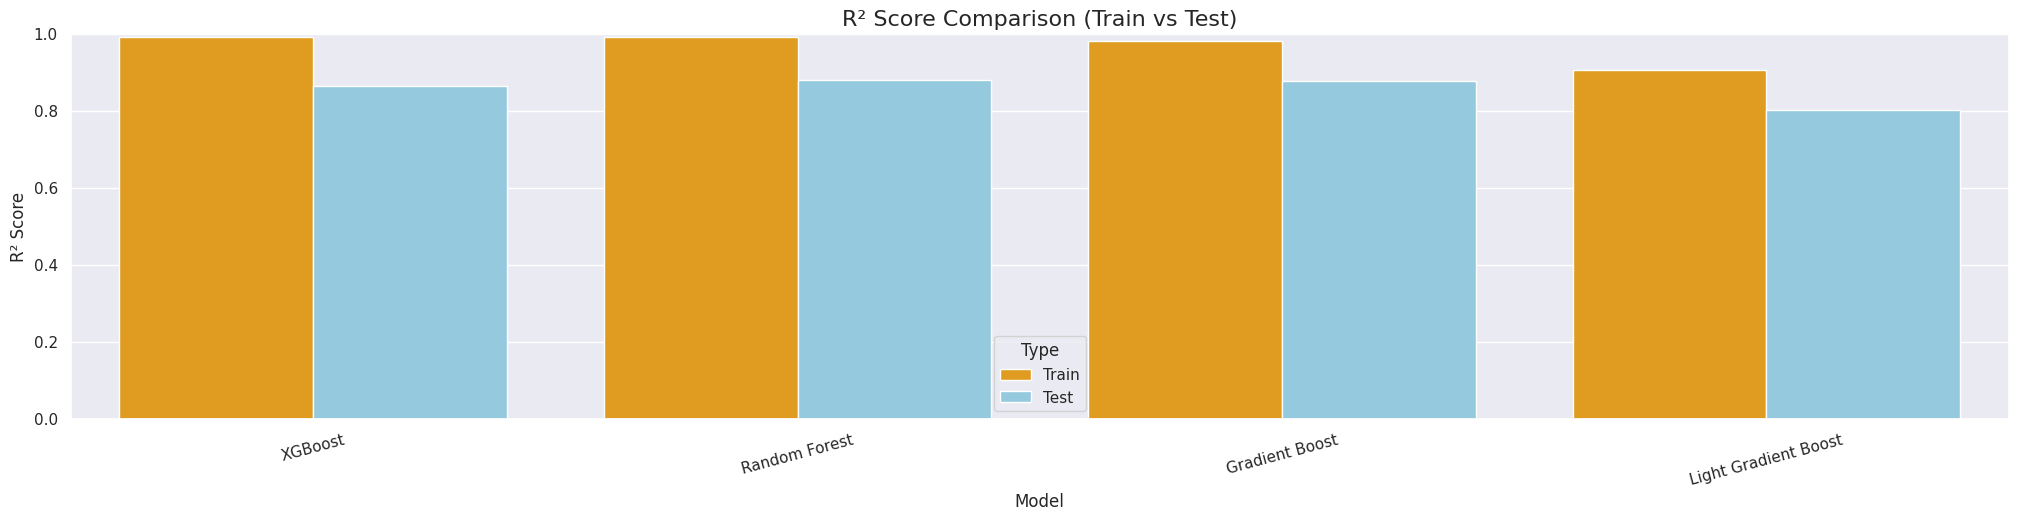

In [ ]:
r2_scores_combined = []

for model in model_train_evaluation:
    r2_scores_combined.append({"Model": model, "Type": "Train", "R² Score": model_train_evaluation[model]["Train R2"]})
    r2_scores_combined.append({"Model": model, "Type": "Test", "R² Score": model_test_evaluation[model]["Test R2"]})

r2_scores_df = pd.DataFrame(r2_scores_combined)

# Plotting R² Score Comparison
sns.set(style="darkgrid")
sns.barplot(x="Model", y="R² Score", hue="Type", data=r2_scores_df, palette=["orange", "skyblue"])
plt.title("R² Score Comparison (Train vs Test)", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.show()

## **7.2 RMSE Comparison**
Here, we compare the Root Mean Squared Error (RMSE) between the train and test sets for each model. RMSE gives us an idea of the average difference between predicted and actual values, and a lower value indicates a better-performing model.

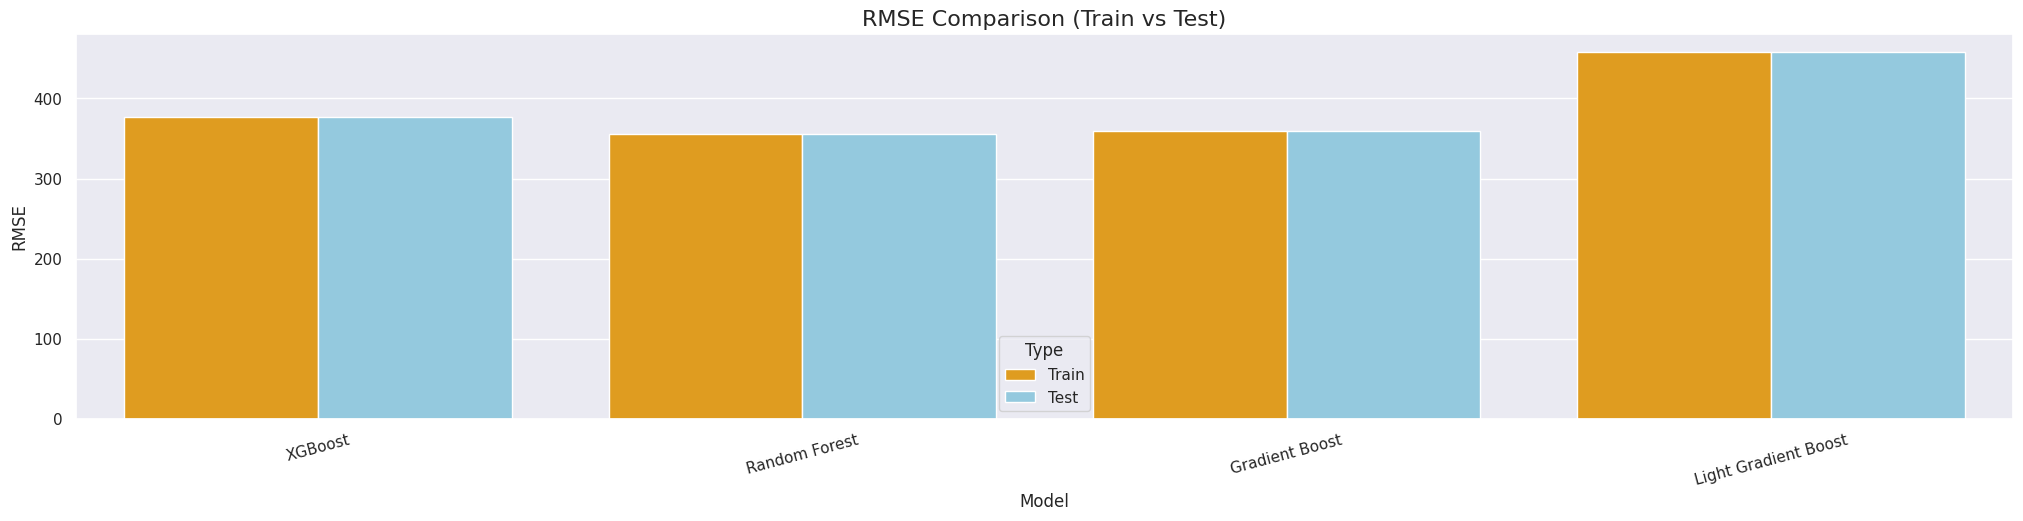

In [ ]:
rmse_scores_combined = []

for model in model_train_evaluation:
    rmse_scores_combined.append({"Model": model, "Type": "Train", "RMSE": model_train_evaluation[model]["Train RMSE"]})
    rmse_scores_combined.append({"Model": model, "Type": "Test", "RMSE": model_test_evaluation[model]["Test RMSE"]})

rmse_scores_df = pd.DataFrame(rmse_scores_combined)

sns.set(style="darkgrid")
sns.barplot(x="Model", y="RMSE", hue="Type", data=rmse_scores_df, palette=["orange", "skyblue"])
plt.title("RMSE Comparison (Train vs Test)", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=15)
plt.show()

## **7.3 MAE Comparison**
This subsection compares the Mean Absolute Error (MAE) between the training and testing datasets for each model. MAE provides the average absolute difference between predicted and actual values, and like RMSE, lower values signify better model performance.

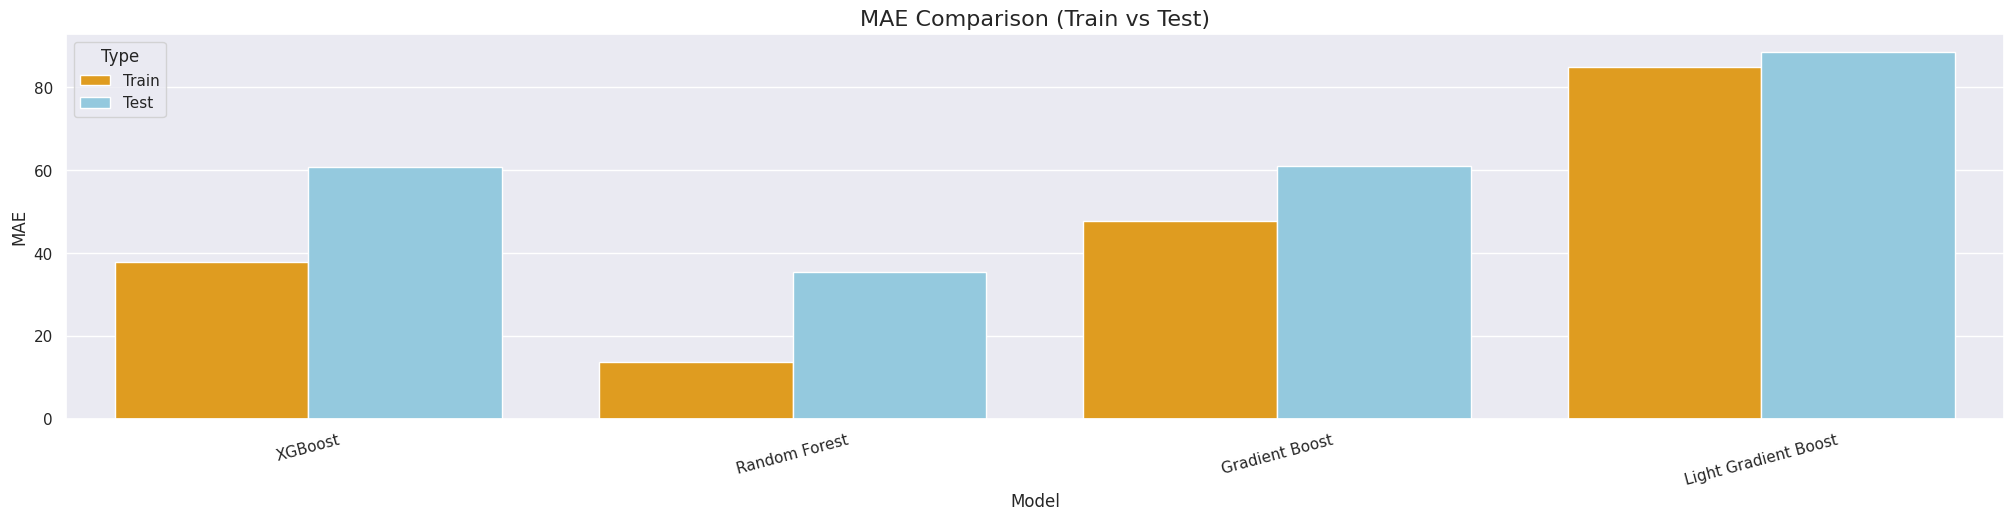

In [ ]:
mae_scores_combined = []

for model in model_train_evaluation:
    mae_scores_combined.append({"Model": model, "Type": "Train", "MAE": model_train_evaluation[model]["Train MAE"]})
    mae_scores_combined.append({"Model": model, "Type": "Test", "MAE": model_test_evaluation[model]["Test MAE"]})

mae_scores_df = pd.DataFrame(mae_scores_combined)

sns.set(style="darkgrid")
sns.barplot(x="Model", y="MAE", hue="Type", data=mae_scores_df, palette=["orange", "skyblue"])
plt.title("MAE Comparison (Train vs Test)", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.xticks(rotation=15)
plt.show()

## **7.4 Predicted vs Actual Comparison**
This section presents a comparison between the actual and predicted values of NOₓ emissions for each model. The closer the predicted values are to the actual values along the diagonal line, the better the model’s predictive accuracy and generalization.

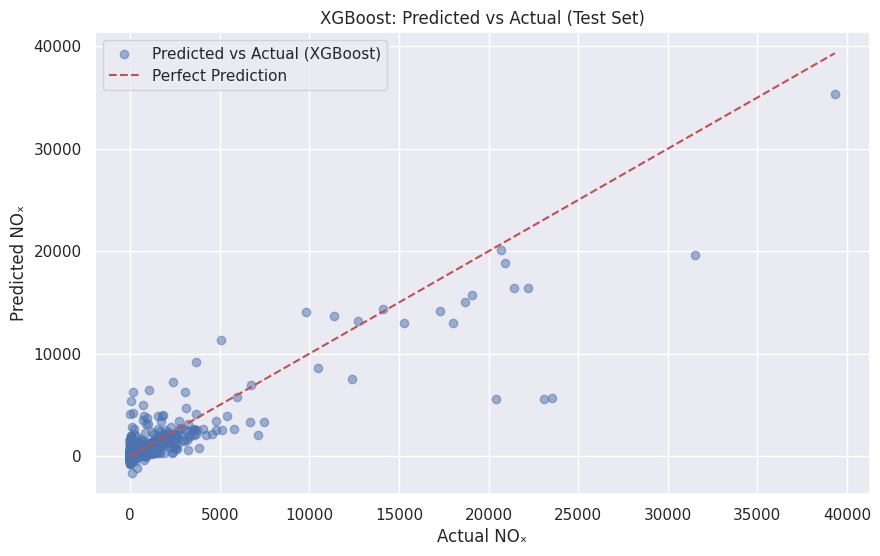

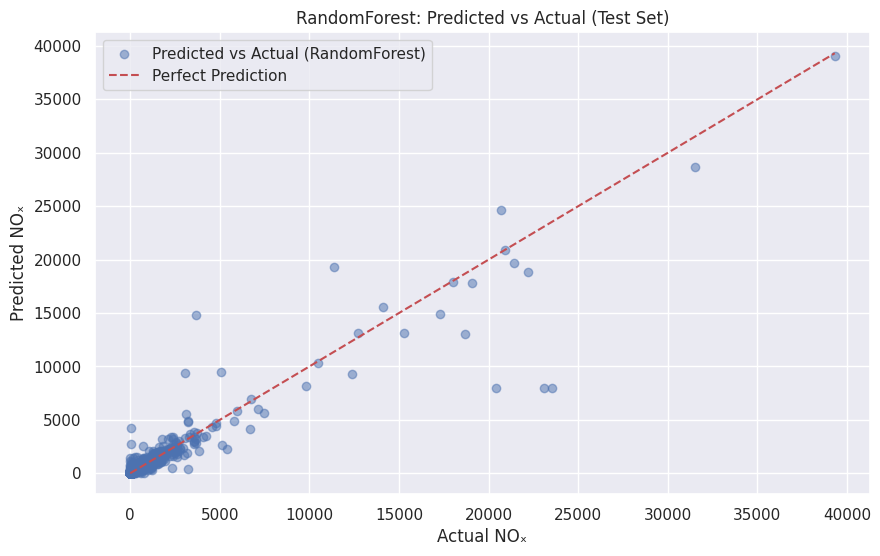

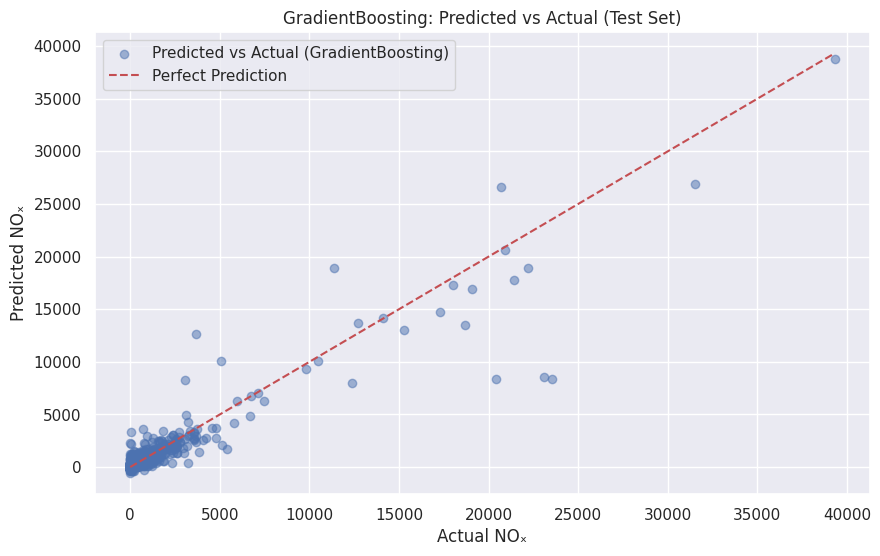

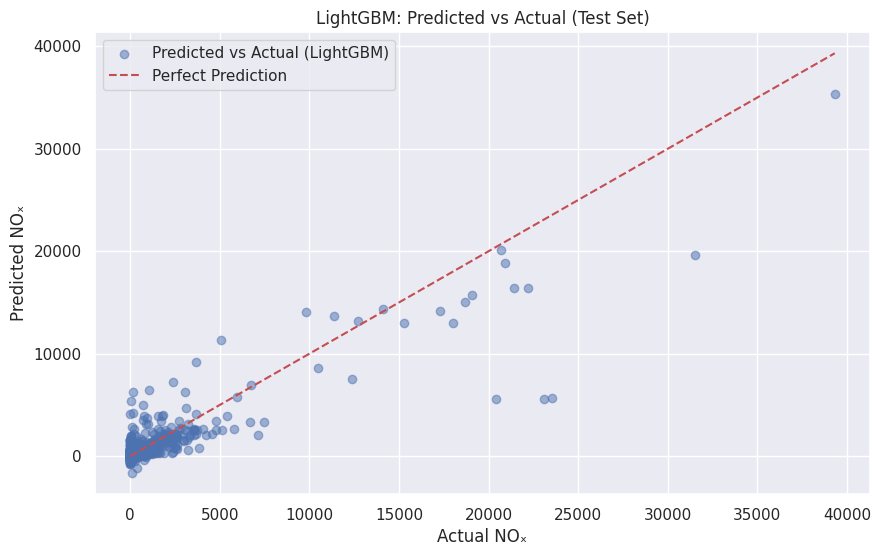

In [ ]:
# Predicted vs Actual for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Predicted vs Actual (XGBoost)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Perfect Prediction")
plt.xlabel("Actual NOₓ")
plt.ylabel("Predicted NOₓ")
plt.title("XGBoost: Predicted vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# Predicted vs Actual for RandomForest
plt.figure(figsize=(10, 6))
y_test_pred_rf = rf_model.predict(X_test)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, label="Predicted vs Actual (RandomForest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Perfect Prediction")
plt.xlabel("Actual NOₓ")
plt.ylabel("Predicted NOₓ")
plt.title("RandomForest: Predicted vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# Predicted vs Actual for GradientBoosting
plt.figure(figsize=(10, 6))
y_test_pred_gb = gb_model.predict(X_test)
plt.scatter(y_test, y_test_pred_gb, alpha=0.5, label="Predicted vs Actual (GradientBoosting)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Perfect Prediction")
plt.xlabel("Actual NOₓ")
plt.ylabel("Predicted NOₓ")
plt.title("GradientBoosting: Predicted vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# Predicted vs Actual for LightGBM
plt.figure(figsize=(10, 6))
y_test_pred_lgb = lgb_model.predict(X_test)
plt.scatter(y_test, y_test_pred_lgb, alpha=0.5, label="Predicted vs Actual (LightGBM)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Perfect Prediction")
plt.xlabel("Actual NOₓ")
plt.ylabel("Predicted NOₓ")
plt.title("LightGBM: Predicted vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


## **7.5 Residual Plot Comparison**
This section displays the residuals (errors) between actual and predicted NOₓ emission values for each model. A well-performing model will exhibit residuals that are randomly scattered around zero, indicating minimal bias and a good fit to the data.

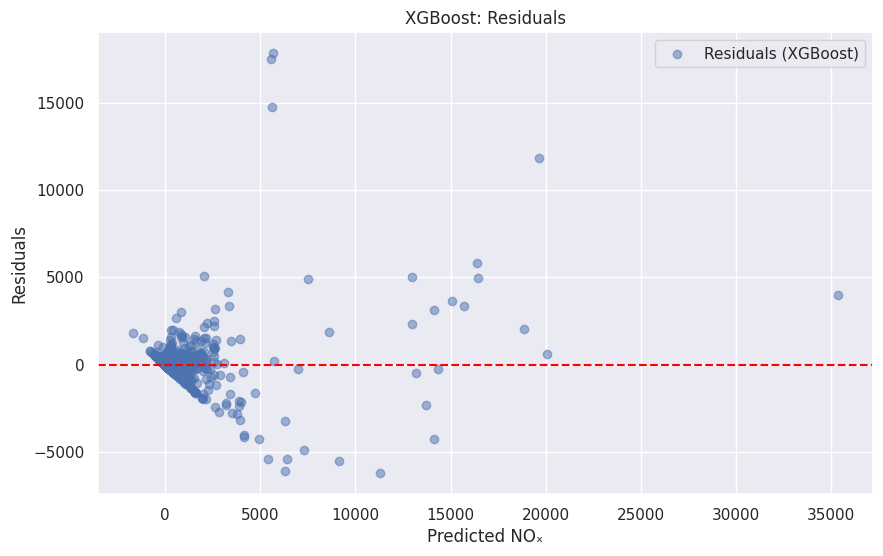

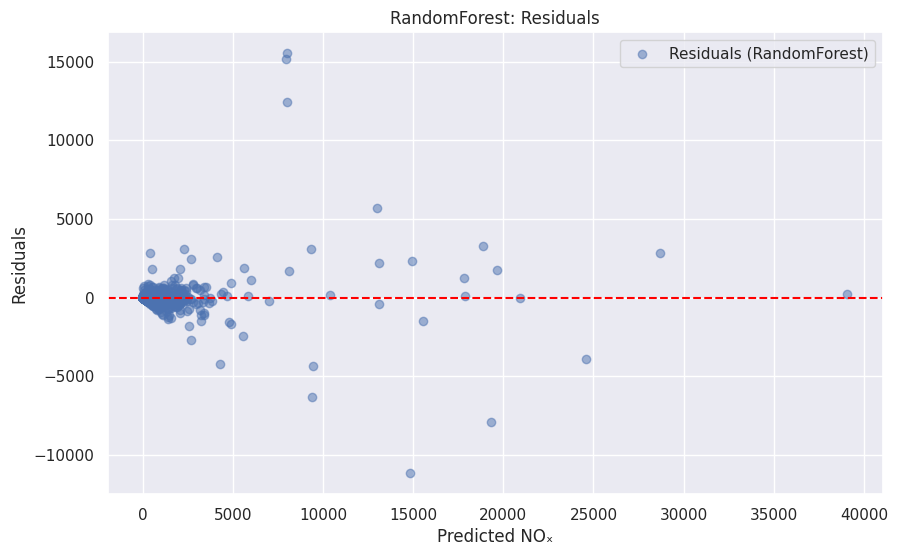

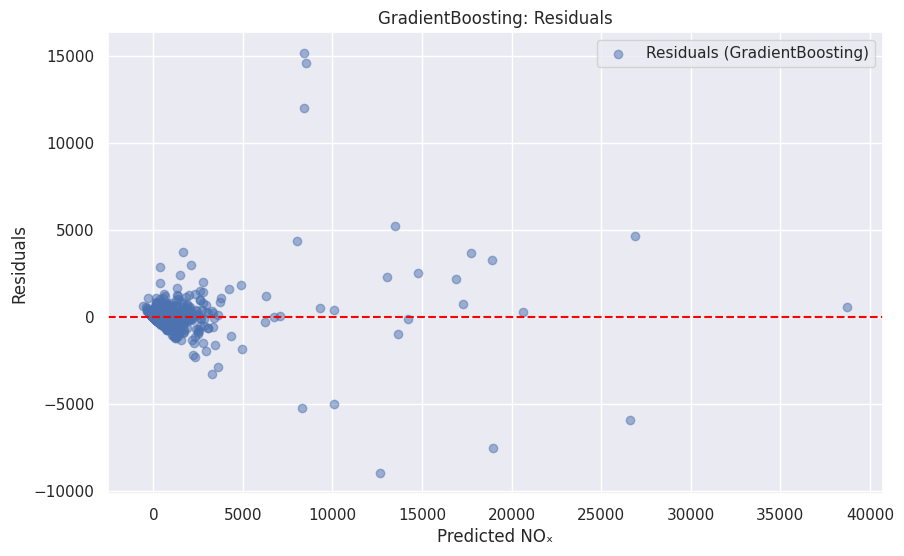

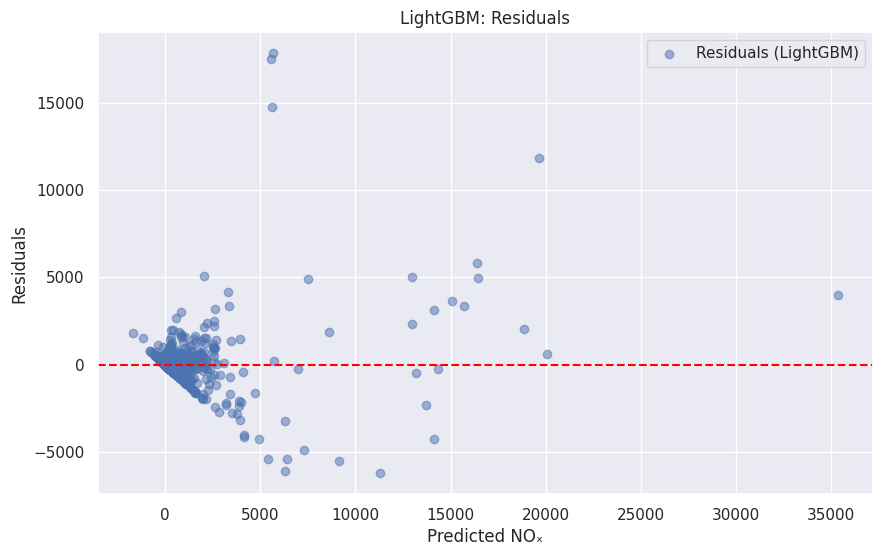

In [ ]:
# Residuals for XGBoost
plt.figure(figsize=(10, 6))
residuals_xgb = y_test - y_test_pred
plt.scatter(y_test_pred, residuals_xgb, alpha=0.5, label="Residuals (XGBoost)")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted NOₓ")
plt.ylabel("Residuals")
plt.title("XGBoost: Residuals")
plt.legend()
plt.grid(True)
plt.show()

# Residuals for RandomForest
plt.figure(figsize=(10, 6))
residuals_rf = y_test - y_test_pred_rf
plt.scatter(y_test_pred_rf, residuals_rf, alpha=0.5, label="Residuals (RandomForest)")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted NOₓ")
plt.ylabel("Residuals")
plt.title("RandomForest: Residuals")
plt.legend()
plt.grid(True)
plt.show()

# Residuals for GradientBoosting
plt.figure(figsize=(10, 6))
residuals_gb = y_test - y_test_pred_gb
plt.scatter(y_test_pred_gb, residuals_gb, alpha=0.5, label="Residuals (GradientBoosting)")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted NOₓ")
plt.ylabel("Residuals")
plt.title("GradientBoosting: Residuals")
plt.legend()
plt.grid(True)
plt.show()

# Residuals for LightGBM
plt.figure(figsize=(10, 6))
residuals_lgb = y_test - y_test_pred_lgb
plt.scatter(y_test_pred_lgb, residuals_lgb, alpha=0.5, label="Residuals (LightGBM)")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted NOₓ")
plt.ylabel("Residuals")
plt.title("LightGBM: Residuals")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
joblib.dump(rf_model, folder_path + 'rf_model.pkl')
print("Model saved as rf_model.pkl")

Model saved as rf_model.pkl
